In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

from feature_selection import RandomForestSelector, LogisticRegressionSelector, SelectorPipeline
from utils import *

## Data

In [20]:
X, y, X_final = load_data('data')
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=42)

Pomysły:
 - ensemble oczywiście
  - ensemble strategii (trzeba sprawdzic 5 roznych strategii wyboru zmiennych, wiec można wybrac te kolumny, ktore powtarzaja sie w wiekszosci z 5)
 - inny model niz xgboost xd
  - albo tez poszukac dobrych parametrow
 - klasteryzacja a potem na klastrach oddzielne modele, albo jako kolumna (narazie nie daje zauwazalnie lepszych wynikow)
 - dodać jakieś interakcje nieliniowe?
 - chyba wiecej niz 1000 customerów moze byc wiec mozna bedzie wziac 1000 tych z najwieksza pewnoscia
 - uważajcie na overfitting

#### Full model

In [21]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', max_depth=3, reg_lambda=10)
model.fit(X_train, y_train)
_ = evaluate_model(model, X_train, y_train, X_test, y_test)
print('--- 20 percent ---')
evaluate_model_20_percent(model, X_test, y_test)

Train accuracy: 0.962, test accuracy: 0.629
Customers who took offer: 476/746 - 63.81% of all who would
Money gained if there were a 1000 possible customers: 6380, money lost: 100000, net gain: -93620
--- 20 percent ---
Number of positive: 211 \ 300
Reward: -97890
Reward if there were 1000 customers: -92966.66666666667


-92966.66666666667

#### Random Forest Selector

In [22]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', max_depth=3, reg_lambda=10)
fs = RandomForestSelector(max_depth=3)
_ = run_train_eval(model, fs, X_train, y_train, X_test, y_test)
print('--- 20 percent ---')
run_train_eval_20_percent(model, fs, X_train, y_train, X_test, y_test)

14 columns: [  0   2   3   4   5   6   8   9 100 101 102 103 104 105]
Train accuracy: 0.813, test accuracy: 0.698
Customers who took offer: 526/746 - 70.51% of all who would
Money gained if there were a 1000 possible customers: 7050, money lost: 2800, net gain: 4250
--- 20 percent ---
13 columns: [  0   1   2   4   5   6   8   9 100 101 102 103 104]
Number of positive: 231 \ 300
Reward: -290
Reward if there were 1000 customers: 5100.0


5100.0

#### L1 Logistic Regression Selector

In [23]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty='l1', C=1.0, solver='liblinear')
model.fit(X_train, y_train)
_ = evaluate_model(model, X_train, y_train, X_test, y_test)
print('--- 20 percent ---')
evaluate_model_20_percent(model, X_test, y_test)

Train accuracy: 0.666, test accuracy: 0.494
Customers who took offer: 374/746 - 50.13% of all who would
Money gained if there were a 1000 possible customers: 5010, money lost: 100000, net gain: -94990
--- 20 percent ---
Number of positive: 151 \ 300
Reward: -98490
Reward if there were 1000 customers: -94966.66666666667


-94966.66666666667

In [24]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', max_depth=3, reg_lambda=10)
fs = LogisticRegressionSelector(C=0.01)
_ = run_train_eval(model, fs, X_train, y_train, X_test, y_test)
print('--- 20 percent ---')
run_train_eval_20_percent(model, fs, X_train, y_train, X_test, y_test)

49 columns: [400 401 403 404 405 407 408 409 410 411 412 415 416 419 420 422 426 429
 431 435 437 442 444 446 450 451 452 458 460 461 462 464 465 466 470 472
 475 476 479 480 484 486 487 489 493 495 496 497 498]
Train accuracy: 0.876, test accuracy: 0.496
Customers who took offer: 365/746 - 48.93% of all who would
Money gained if there were a 1000 possible customers: 4890, money lost: 9800, net gain: -4910
--- 20 percent ---
49 columns: [400 401 403 404 405 407 408 409 410 411 412 415 416 419 420 422 426 429
 431 435 437 442 444 446 450 451 452 458 460 461 462 464 465 466 470 472
 475 476 479 480 484 486 487 489 493 495 496 497 498]
Number of positive: 142 \ 300
Reward: -8380
Reward if there were 1000 customers: -5066.666666666667


-5066.666666666667

#### Multiple selectors

In [25]:
pipe = SelectorPipeline(selectors=[
    RandomForestSelector(max_depth=3),
    RandomForestSelector(max_depth=3),
    RandomForestSelector(max_depth=3),
    RandomForestSelector(max_depth=3)
], method='pipeline')

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', max_depth=3, reg_lambda=10)
_ = run_train_eval(model, pipe, X_train, y_train, X_test, y_test)
print('--- 20 percent ---')
run_train_eval_20_percent(model, pipe, X_train, y_train, X_test, y_test)

Selector 1/4
Selector 2/4
Selector 3/4
Selector 4/4
5 columns: [100 101 102 103 105]
Train accuracy: 0.751, test accuracy: 0.667
Customers who took offer: 499/746 - 66.89% of all who would
Money gained if there were a 1000 possible customers: 6680, money lost: 1000, net gain: 5680
--- 20 percent ---
Selector 1/4
Selector 2/4
Selector 3/4
Selector 4/4
5 columns: [100 101 102 103 105]
Number of positive: 228 \ 300
Reward: 1280
Reward if there were 1000 customers: 6600.0


6600.0

In [26]:
pipe = SelectorPipeline(selectors=[
    LogisticRegressionSelector(C=0.01),
    RandomForestSelector(max_depth=3),
    RandomForestSelector(max_depth=5),
    LogisticRegressionSelector(C=0.1),
    RandomForestSelector(max_depth=2)
], method='bagging')

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', max_depth=3, reg_lambda=10)
_ = run_train_eval(model, pipe, X_train, y_train, X_test, y_test)
print('--- 20 percent ---')
run_train_eval_20_percent(model, pipe, X_train, y_train, X_test, y_test)

Selector 1/5
Selector 2/5
Selector 3/5
Selector 4/5
Selector 5/5
11 columns: [  0   1   2   3   5   6 100 102 103 104 105]
Train accuracy: 0.787, test accuracy: 0.681
Customers who took offer: 501/746 - 67.16% of all who would
Money gained if there were a 1000 possible customers: 6710, money lost: 2200, net gain: 4510
--- 20 percent ---
Selector 1/5
Selector 2/5
Selector 3/5
Selector 4/5
Selector 5/5
8 columns: [  0   1   9 100 101 102 103 105]
Number of positive: 219 \ 300
Reward: 590
Reward if there were 1000 customers: 5700.0


5700.0

In [ ]:
pipe = SelectorPipeline(selectors=[
    RandomForestSelector(max_depth=3),
    LogisticRegressionSelector(C=1),
    RandomForestSelector(max_depth=5),
    LogisticRegressionSelector(C=0.7),
    RandomForestSelector(max_depth=3)
], method='pipeline')

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', max_depth=3, reg_lambda=10)
_ = run_train_eval(model, pipe, X_train, y_train, X_test, y_test)
print('--- 20 percent ---')
run_train_eval_20_percent(model, pipe, X_train, y_train, X_test, y_test)

Selector 1/5
Selector 2/5
Selector 3/5
Selector 4/5
Selector 5/5
4 columns: [100 101 103 105]
Train accuracy: 0.725, test accuracy: 0.653
Customers who took offer: 482/746 - 64.61% of all who would
Money gained if there were a 1000 possible customers: 6460, money lost: 800, net gain: 5660
--- 20 percent ---
Selector 1/5
Selector 2/5
Selector 3/5
Selector 4/5
Selector 5/5
5 columns: [100 101 102 103 105]
Number of positive: 228 \ 300
Reward: 1280
Reward if there were 1000 customers: 6600.0


6600.0

In [ ]:
X_train_tree = X_train
X_test_tree = X_test
cols_old = list(range(X_train_tree.shape[-1]))

np.random.seed(42)
for i in range(5):
    fs = RandomForestSelector(max_depth=3)
    X_train_tree = fs.fit_transform(X_train_tree, y_train)
    X_test_tree = fs.transform(X_test)
    print(f'-----------Loop {i+1}----Columns {len(fs.selected_features)}--------')
    if len(cols_old) <= len(fs.selected_features):
        print('No change\n')
        continue
    else:
        print('Columns:', fs.selected_features)
        cols_old = fs.selected_features
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', max_depth=3, reg_lambda=10)
    model.fit(X_train_tree, y_train)
    evaluate_model(model, X_train_tree, y_train, X_test_tree, y_test)
    print('--- 20 percent ---')
    evaluate_model_20_percent(model, X_test_tree, y_test)

-----------Loop 1----Columns 8--------
Columns: [  3   5 100 101 102 103 104 105]
Train accuracy: 0.787, test accuracy: 0.695
Customers who took offer: 523/746 - 70.11% of all who would
Money gained if there were a 1000 possible customers: 7010, money lost: 1600, net gain: 5410
--- 20 percent ---
Number of positive: 223 \ 300
Reward: 630
Reward if there were 1000 customers: 5833.333333333333
-----------Loop 2----Columns 6--------
Columns: [  5 100 101 102 103 105]
Train accuracy: 0.761, test accuracy: 0.673
Customers who took offer: 502/746 - 67.29% of all who would
Money gained if there were a 1000 possible customers: 6720, money lost: 1200, net gain: 5520
--- 20 percent ---
Number of positive: 220 \ 300
Reward: 1000
Reward if there were 1000 customers: 6133.333333333333
-----------Loop 3----Columns 5--------
Columns: [100 101 102 103 105]
Train accuracy: 0.751, test accuracy: 0.667
Customers who took offer: 499/746 - 66.89% of all who would
Money gained if there were a 1000 possible 

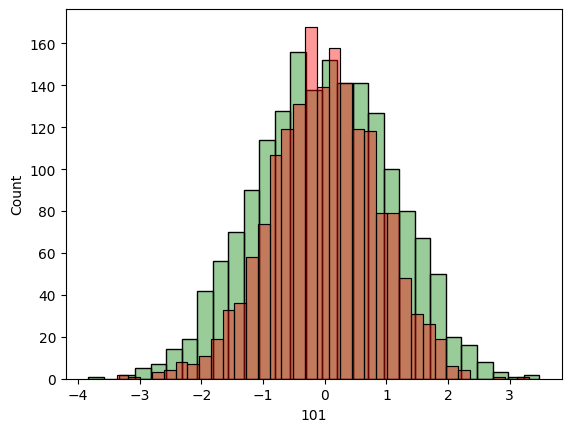

In [ ]:
col=101
sns.histplot(X_train.loc[(y_train==1), col], color='green', alpha=0.4)
sns.histplot(X_train.loc[(y_train==0), col], color='red', alpha=0.4)
plt.show()

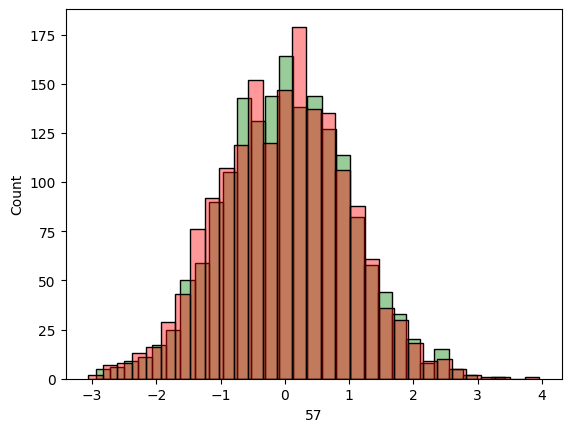

In [ ]:
col=57
sns.histplot(X_train.loc[(y_train==1), col], color='green', alpha=0.4)
sns.histplot(X_train.loc[(y_train==0), col], color='red', alpha=0.4)
plt.show()

# klasteryzacja jako dodatkowa kolumna

In [ ]:
from sklearn.mixture import GaussianMixture

In [ ]:
pipe = SelectorPipeline(selectors=[
    RandomForestSelector(max_depth=3),
    RandomForestSelector(max_depth=3),
    RandomForestSelector(max_depth=3),
], method='pipeline')
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', max_depth=3, reg_lambda=10)

X_train_cluster = pipe.fit_transform(X_train, y_train)
X_test_cluster = pipe.transform(X_test)
print(pipe.selected_features)

print('Without clustering')
model.fit(X_train_cluster, y_train)
_ = evaluate_model(model, X_train_cluster, y_train, X_test_cluster, y_test, n_vars=len(pipe.selected_features))
print('--- 20 percent ---')
evaluate_model_20_percent(model, X_test_cluster, y_test)

np.random.seed(42)
cluster = GaussianMixture(n_components=5)
cluster.fit(X_train_cluster)
train_clusters = cluster.predict(X_train_cluster)
test_clusters = cluster.predict(X_test_cluster)
X_train_cluster['cluster'] = train_clusters
X_test_cluster['cluster'] = test_clusters

print('With clustering')
model.fit(X_train_cluster, y_train)
_ = evaluate_model(model, X_train_cluster, y_train, X_test_cluster, y_test, n_vars=len(pipe.selected_features))
print('--- 20 percent ---')
evaluate_model_20_percent(model, X_test_cluster, y_test)

Selector 1/3
Selector 2/3
Selector 3/3
[100 101 102 103 105]
Without clustering
Train accuracy: 0.751, test accuracy: 0.667
Customers who took offer: 499/746 - 66.89% of all who would
Money gained if there were a 1000 possible customers: 6680, money lost: 1000, net gain: 5680
--- 20 percent ---
Number of positive: 228 \ 300
Reward: 1280
Reward if there were 1000 customers: 6600.0
With clustering
Train accuracy: 0.756, test accuracy: 0.671
Customers who took offer: 504/746 - 67.56% of all who would
Money gained if there were a 1000 possible customers: 6750, money lost: 1000, net gain: 5750
--- 20 percent ---
Number of positive: 224 \ 300
Reward: 1040
Reward if there were 1000 customers: 6266.666666666667


6266.666666666667

### Szukanie hiperparametrów dla xgboosta.

In [3]:
from hyperopt import hp, STATUS_OK, Trials, fmin, tpe

X_train_selected = X_train.iloc[:, [100, 101, 102, 103, 104, 105]]
X_test_selected = X_test.iloc[:, [100, 101, 102, 103, 104, 105]]

space={'max_depth': hp.quniform("max_depth", 1, 50, 1),
        'gamma': hp.uniform ('gamma', 0, 10),
        'reg_alpha' : hp.uniform('reg_alpha', 0,100),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.2,1),
        'min_child_weight' : hp.uniform('min_child_weight', 0, 10),
        'n_estimators': hp.quniform('n_estimators', 100,1000, 1),
        'seed': 0
    }

def objective(space):
    clf = XGBClassifier(
        n_estimators = int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
        reg_alpha = space['reg_alpha'],min_child_weight=space['min_child_weight'],
        colsample_bytree=space['colsample_bytree'],
        eval_metric='logloss',early_stopping_rounds=10)
    
    evaluation = [(X_train_selected, y_train), (X_test_selected, y_test)]

    clf.fit(X_train_selected, y_train,
            eval_set=evaluation, verbose=False)

    reward = evaluate_model_20_percent(clf, X_test_selected, y_test, print_ = False)    
    return {'loss': -reward, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn=objective,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=2000,
                        trials=trials)

  0%|          | 0/2000 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 2000/2000 [05:04<00:00,  6.56trial/s, best loss: -6733.333333333333]


In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

best_hyperparams['n_estimators'] = int(best_hyperparams['n_estimators'])
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])

The best hyperparameters are :  

{'colsample_bytree': 0.7508390154610193, 'gamma': 3.480469407444721, 'max_depth': 34, 'min_child_weight': 9.983463991297763, 'n_estimators': 749, 'reg_alpha': 0.046897302721050804, 'reg_lambda': 0.5797058057794593}


In [ ]:
model = XGBClassifier(**best_hyperparams)
model.fit(X_train_selected, y_train)
_ = evaluate_model(model, X_train_selected, y_train, X_test_selected, y_test)
print('--- 20 percent ---')
evaluate_model_20_percent(model, X_test_selected, y_test)

Train accuracy: 0.762, test accuracy: 0.691
Customers who took offer: 532/746 - 71.31% of all who would
Money gained if there were a 1000 possible customers: 7130, money lost: 1200, net gain: 5930
--- 20 percent ---
Number of positive: 225 \ 300
Reward: 1050
Reward if there were 1000 customers: 6300.0


6300.0

### SHAP

c:\Users\ltoma\anaconda3\envs\AML\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


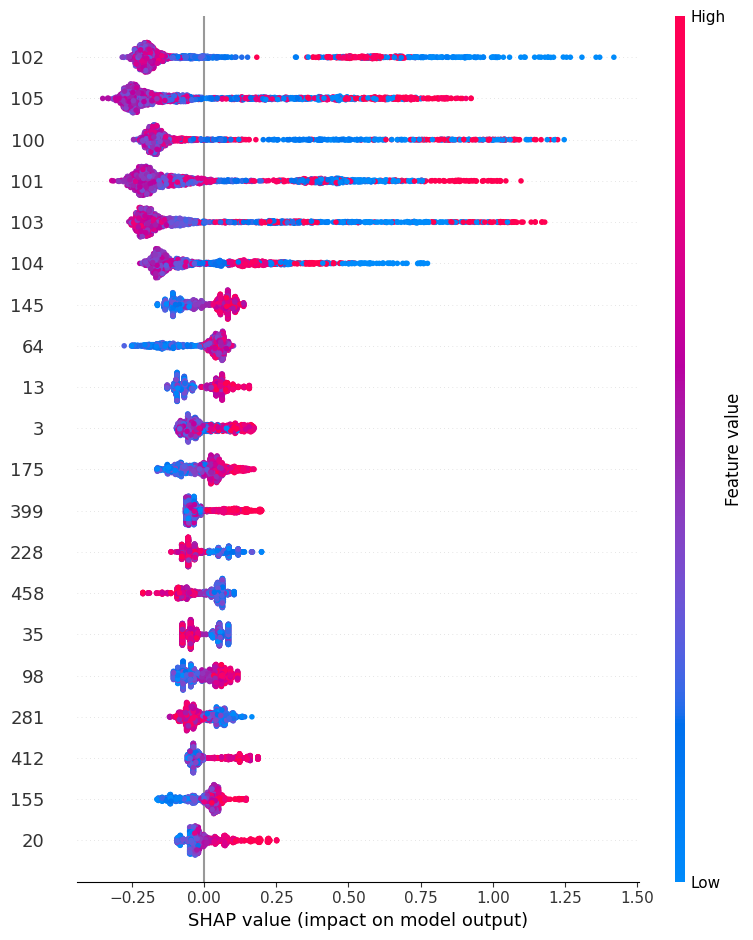

In [4]:
import shap
shap.initjs()
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', max_depth=3, reg_lambda=10)
model.fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

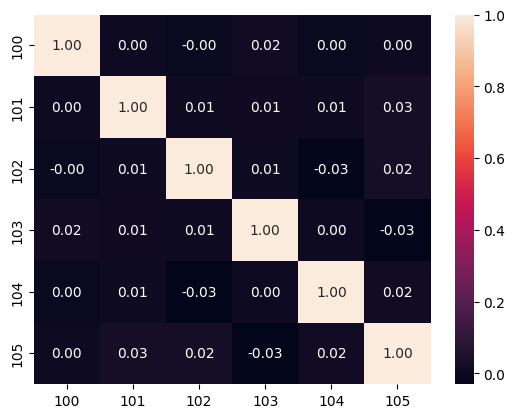

In [ ]:
X_train_selected = X_train.iloc[:, [100, 101, 102, 103, 104, 105]]
sns.heatmap(X_train_selected.corr(), annot=True, fmt=".2f")
plt.show()

### LightGBM

In [ ]:
import lightgbm as lgb

In [ ]:
lgbm_train = lgb.Dataset(X_train, label=y_train)
lgbm_test = lgb.Dataset(X_test, label=y_test, reference=lgbm_train)

[LightGBM] [Info] Number of positive: 1750, number of negative: 1750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 3500, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\ltoma\anaconda3\envs\AML\lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


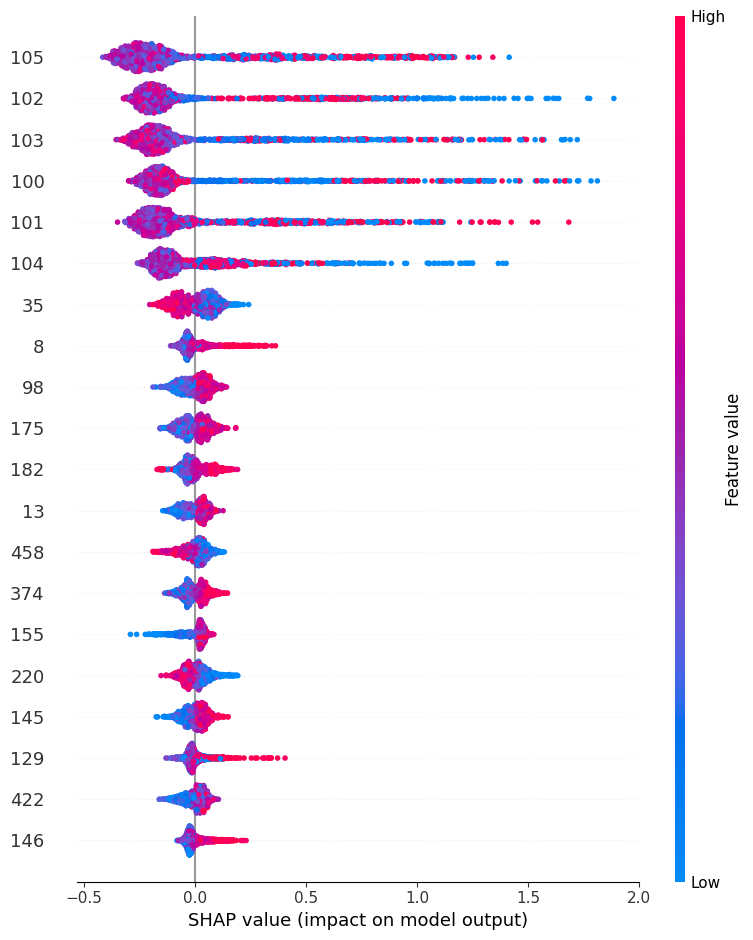

In [ ]:
lgbm_model = lgb.LGBMClassifier(objective='binary', metric='binary_logloss')
lgbm_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='logloss')
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [ ]:
X_train_selected = X_train.iloc[:, [100, 101, 102, 103, 105]]
X_test_selected = X_test.iloc[:, [100, 101, 102, 103, 105]]

space={'num_leaves': hp.quniform("num_leaves", 2, 100, 1),
        'learning_rate': hp.uniform("learning_rate", 0.001, 0.1),
        'n_estimators': hp.quniform("n_estimators", 10, 1000, 1),
        'reg_alpha' : hp.uniform('reg_alpha', 0,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.2,1),
        'min_child_weight' : hp.uniform('min_child_weight', 0, 10),

        
       }

def objective(space):
    clf = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', num_leaves=int(space['num_leaves']),
                                learning_rate=space['learning_rate'], n_estimators=int(space['n_estimators']),
                                verbosity=-1)
    
    evaluation = [(X_train_selected, y_train), (X_test_selected, y_test)]

    clf.fit(X_train_selected, y_train,
            eval_set=evaluation)

    reward = evaluate_model_20_percent(clf, X_test_selected, y_test, print_ = False)    
    return {'loss': -reward, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn=objective,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=3000,
                        trials=trials)

100%|██████████| 3000/3000 [12:37<00:00,  3.96trial/s, best loss: -6733.333333333333]


In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

best_hyperparams['n_estimators'] = int(best_hyperparams['n_estimators'])
best_hyperparams['num_leaves'] = int(best_hyperparams['num_leaves'])

The best hyperparameters are :  

{'colsample_bytree': 0.7982750735637858, 'learning_rate': 0.03231678425907167, 'min_child_weight': 5.283262737827822, 'n_estimators': 96.0, 'num_leaves': 37.0, 'reg_alpha': 0.7578035573870079, 'reg_lambda': 0.3179471251297103}


In [ ]:
model = lgb.LGBMClassifier(**best_hyperparams)
model.fit(X_train_selected, y_train)
_ = evaluate_model(model, X_train_selected, y_train, X_test_selected, y_test)
print('--- 20 percent ---')
evaluate_model_20_percent(model, X_test_selected, y_test)

[LightGBM] [Info] Number of positive: 1750, number of negative: 1750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 3500, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Train accuracy: 0.789, test accuracy: 0.674
Customers who took offer: 515/746 - 69.03% of all who would
Money gained if there were a 1000 possible customers: 6900, money lost: 1000, net gain: 5900
--- 20 percent ---
Number of positive: 229 \ 300
Reward: 1290
Reward if there were 1000 customers: 6633.333333333333


6633.333333333333

### Iteracyjne odrzucanie 

In [5]:
from hyperopt import hp, STATUS_OK, Trials, fmin, tpe
import shap


space={'max_depth': hp.quniform("max_depth", 1, 50, 1),
        'gamma': hp.uniform ('gamma', 0, 10),
        'reg_alpha' : hp.uniform('reg_alpha', 0,100),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.2,1),
        'min_child_weight' : hp.uniform('min_child_weight', 0, 10),
        'n_estimators': hp.quniform('n_estimators', 100,1000, 1),
        'seed': 0
    }

def objective(space):
    clf = XGBClassifier(
        n_estimators = int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
        reg_alpha = space['reg_alpha'],min_child_weight=space['min_child_weight'],
        colsample_bytree=space['colsample_bytree'],
        eval_metric='logloss',early_stopping_rounds=10)
    
    evaluation = [(X_train_selected, y_train), (X_test_selected, y_test)]

    clf.fit(X_train_selected, y_train,
            eval_set=evaluation, verbose=False)

    reward = evaluate_model_20_percent(clf, X_test_selected, y_test, print_ = False)    
    return {'loss': -reward, 'status': STATUS_OK }

X_train_selected = X_train
X_test_selected = X_test

for i in range(10):
    print(f'-----------Loop {i+1}----Columns {X_train_selected.shape[-1]}--------')
    print('Columns:', X_train_selected.columns)
    if i < 2:
        evals = 300
    elif i < 5:
        evals = 500
    else:
        evals = 1000
    trials = Trials()
    best_hyperparams = fmin(fn=objective,
                            space=space,
                            algo=tpe.suggest,
                            max_evals=evals,
                            trials=trials)
    best_hyperparams['n_estimators'] = int(best_hyperparams['n_estimators'])
    best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
    print(best_hyperparams)
    model = XGBClassifier(**best_hyperparams)
    model.fit(X_train_selected, y_train)
    _ = evaluate_model(model, X_train_selected, y_train, X_test_selected, y_test)
    print('--- 20 percent ---')
    evaluate_model_20_percent(model, X_test_selected, y_test)
    if i == 9:
        break
    shap.initjs()
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_selected)
    idx = X_train_selected.columns[np.argsort(np.abs(shap_values).mean(0))][len(X_train_selected.columns)//2:]
    X_train_selected = X_train_selected[idx]
    X_test_selected = X_test_selected[idx]
    

    

-----------Loop 1----Columns 500--------
Columns: Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       490, 491, 492, 493, 494, 495, 496, 497, 498, 499],
      dtype='int64', length=500)
  1%|▏         | 4/300 [00:07<09:18,  1.89s/trial, best loss: 92966.66666666667]


KeyboardInterrupt: 

### Porównanie dla różnej ilości zmiennych

In [6]:
import itertools

In [4]:
relevant_columns = [100, 101, 102, 103, 105]

In [5]:
best_parameters = {'colsample_bytree': 0.7508390154610193, 'gamma': 3.480469407444721, 'max_depth': 34, 'min_child_weight': 9.983463991297763, 'n_estimators': 749, 'reg_alpha': 0.046897302721050804, 'reg_lambda': 0.5797058057794593}

In [6]:
X_train1 = X_train.iloc[:, relevant_columns]
X_test1 = X_test.iloc[:, relevant_columns]

In [7]:
model = XGBClassifier(**best_parameters)
model.fit(X_train1, y_train)
reward = evaluate_model(model, X_train1, y_train, X_test1, y_test)
y_pred_probs_full = model.predict_proba(X_test1)[:, 1]
indices_full = np.argsort(y_pred_probs_full)[-1000:]
print(reward)

Train accuracy: 0.734, test accuracy: 0.673
Customers who took offer: 511/746 - 68.50% of all who would
Money gained if there were a 1000 possible customers: 6840, money lost: 1000, net gain: 5840
5840


In [23]:
def evaluate_number_of_variables(important_columns_ids, indices, n_to_remove=1):
    n = len(important_columns_ids)
    combinations = itertools.combinations(list(range(n)), n_to_remove)
    max_reward = float('-inf')
    best_subset=None
    best_indices = None
    number_of_diffs = len(y_test)
    for comb in combinations:
        sublist = [important_columns_ids[i] for i in range(n) if i not in comb]
        X_train_new = X_train.iloc[:, sublist]
        X_test_new = X_test.iloc[:, sublist]
        print(f'model with features: {sublist}')
        model = XGBClassifier(**best_parameters)
        model.fit(X_train_new, y_train)
        reward = evaluate_model(model, X_train_new, y_train, X_test_new, y_test)
        print(f'reward: {reward}')
        y_probs_new = model.predict_proba(X_test_new)[:,1]
        indices_new = np.argsort(y_probs_new)[-1000:]
        diffs_num = count_different_elements(indices, indices_new)
        print(f'number of different indices among the 1000: {diffs_num}')
        if reward > max_reward:
            max_reward = reward
            best_subset = sublist
            number_of_diffs = diffs_num
            best_indices = indices_new
        print('--- 20 percent ---')
        evaluate_model_20_percent(model, X_test_new, y_test)
    print(f'best achieved reward: {max_reward} for variables: {best_subset}, number of elements different than the dataset with 5 variables: {diffs_num}')
    return best_indices

In [24]:
def count_different_elements(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    only_in_first = set1 - set2
    only_in_second = set2 - set1
    return max(len(only_in_first), len(only_in_second))

In [25]:
indices_minus_one = evaluate_number_of_variables(relevant_columns, indices_full, 1)

model with features: [101, 102, 103, 105]
Train accuracy: 0.703, test accuracy: 0.649
Customers who took offer: 483/746 - 64.75% of all who would
Money gained if there were a 1000 possible customers: 6470, money lost: 800, net gain: 5670
reward: 5670
number of different indices among the 1000: 101
--- 20 percent ---
Number of positive: 220 \ 300
Reward: 1400
Reward if there were 1000 customers: 6533.333333333333
model with features: [100, 102, 103, 105]
Train accuracy: 0.707, test accuracy: 0.651
Customers who took offer: 481/746 - 64.48% of all who would
Money gained if there were a 1000 possible customers: 6440, money lost: 800, net gain: 5640
reward: 5640
number of different indices among the 1000: 103
--- 20 percent ---
Number of positive: 219 \ 300
Reward: 1390
Reward if there were 1000 customers: 6500.0
model with features: [100, 101, 103, 105]
Train accuracy: 0.705, test accuracy: 0.658
Customers who took offer: 485/746 - 65.01% of all who would
Money gained if there were a 1000

In [26]:
indices_minus_two = evaluate_number_of_variables(relevant_columns, indices_minus_one, 2)

model with features: [102, 103, 105]
Train accuracy: 0.669, test accuracy: 0.613
Customers who took offer: 430/746 - 57.64% of all who would
Money gained if there were a 1000 possible customers: 5760, money lost: 600, net gain: 5160
reward: 5160
number of different indices among the 1000: 198
--- 20 percent ---
Number of positive: 221 \ 300
Reward: 1610
Reward if there were 1000 customers: 6766.666666666667
model with features: [101, 103, 105]
Train accuracy: 0.671, test accuracy: 0.612
Customers who took offer: 441/746 - 59.12% of all who would
Money gained if there were a 1000 possible customers: 5910, money lost: 600, net gain: 5310
reward: 5310
number of different indices among the 1000: 210
--- 20 percent ---
Number of positive: 202 \ 300
Reward: 1420
Reward if there were 1000 customers: 6133.333333333333
model with features: [101, 102, 105]
Train accuracy: 0.661, test accuracy: 0.620
Customers who took offer: 450/746 - 60.32% of all who would
Money gained if there were a 1000 pos

### AdaBoost

In [27]:
from sklearn.ensemble import AdaBoostClassifier

In [28]:
relevant_columns = [100, 101, 102, 103, 105]

In [29]:
adaboost = AdaBoostClassifier(n_estimators=70)

In [30]:
X_train_selected = X_train.iloc[:, relevant_columns]
X_test_selected = X_test.iloc[:, relevant_columns]

In [31]:
adaboost.fit(X_train_selected, y_train)

c:\Users\ltoma\anaconda3\envs\AML\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(n_estimators=70)

In [32]:
evaluate_model(adaboost, X_train_selected, y_train, X_test_selected, y_test)

Train accuracy: 0.698, test accuracy: 0.677
Customers who took offer: 486/746 - 65.15% of all who would
Money gained if there were a 1000 possible customers: 6510, money lost: 1000, net gain: 5510


5510

In [33]:
evaluate_model_20_percent(adaboost, X_test_selected, y_test)

Number of positive: 221 \ 300
Reward: 1210
Reward if there were 1000 customers: 6366.666666666667


6366.666666666667

### SVM

In [7]:
from sklearn.svm import SVC

In [85]:
svc = SVC(probability=True)

In [86]:
svc.fit(X_train_selected, y_train)

SVC(probability=True)

In [87]:
evaluate_model(svc, X_train_selected, y_train, X_test_selected, y_test)

Train accuracy: 0.707, test accuracy: 0.682
Customers who took offer: 509/746 - 68.23% of all who would
Money gained if there were a 1000 possible customers: 6820, money lost: 1000, net gain: 5820


5820

In [88]:
evaluate_model_20_percent(svc, X_test_selected, y_test)

Number of positive: 237 \ 300
Reward: 1370
Reward if there were 1000 customers: 6900.0


6900.0

Parameters optimization for SVM classifier:

In [89]:
from sklearn.model_selection import GridSearchCV

In [90]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf', 'linear']
}

In [91]:
grid_search_svm = GridSearchCV(SVC(), param_grid, verbose=False, cv=5)

In [92]:
grid_search_svm.fit(X_train_selected, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['rbf', 'linear']},
             verbose=False)

In [93]:
grid_search_svm.best_params_

{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}

In [98]:
svc = SVC(**grid_search_svm.best_params_, probability=True)

In [99]:
svc.fit(X_train_selected, y_train)

SVC(C=0.1, gamma=0.1, probability=True)

In [100]:
evaluate_model(svc, X_train_selected, y_train, X_test_selected, y_test)

Train accuracy: 0.696, test accuracy: 0.692
Customers who took offer: 511/746 - 68.50% of all who would
Money gained if there were a 1000 possible customers: 6840, money lost: 1000, net gain: 5840


5840

In [101]:
evaluate_model_20_percent(svc, X_test_selected, y_test)

Number of positive: 230 \ 300
Reward: 1300
Reward if there were 1000 customers: 6666.666666666667


6666.666666666667

In [13]:
X_train_selected = X_train.iloc[:, [100, 101, 102, 103, 105]]
X_test_selected = X_test.iloc[:, [100, 101, 102, 103, 105]]

space={
    'C': hp.uniform('C',0.1, 10),
    'gamma': hp.uniform('gamma',0.01, 10),
    'kernel': hp.choice('kernel', ['rbf', 'linear'])
    }

def objective(space):
    clf = SVC(C=space['C'], gamma=space['gamma'], kernel=space['kernel'], probability=True)
    
    evaluation = [(X_train_selected, y_train), (X_test_selected, y_test)]

    clf.fit(X_train_selected, y_train)

    reward = evaluate_model_20_percent(clf, X_test_selected, y_test, print_ = False)    
    return {'loss': -reward, 'status': STATUS_OK }

In [14]:
trials = Trials()

best_hyperparams = fmin(fn=objective,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=500,
                        trials=trials)

100%|██████████| 500/500 [17:24<00:00,  2.09s/trial, best loss: -6966.666666666667]


In [34]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

best_hyperparams['kernel'] = ['rbf', 'linear'][best_hyperparams['kernel']]

The best hyperparameters are :  

{'C': 0.12913204366443143, 'gamma': 1.1414493688865297, 'kernel': 'rbf'}


TypeError: list indices must be integers or slices, not str

In [35]:
model = SVC(**{'C': 0.12913204366443143, 'gamma': 1.1414493688865297, 'kernel': 'rbf'}, probability=True)
model.fit(X_train_selected, y_train)
_ = evaluate_model(model, X_train_selected, y_train, X_test_selected, y_test)
print('--- 20 percent ---')
evaluate_model_20_percent(model, X_test_selected, y_test)

Train accuracy: 0.705, test accuracy: 0.659
Customers who took offer: 579/746 - 77.61% of all who would
Money gained if there were a 1000 possible customers: 7760, money lost: 1000, net gain: 6760
--- 20 percent ---
Number of positive: 239 \ 300
Reward: 1390
Reward if there were 1000 customers: 6966.666666666667


6966.666666666667